Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [184]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE


Download the data from the source website if necessary.

In [185]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified {0}, size: {1}'.format(filename, statinfo.st_size))
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip, size: 31344016


Read the data into a string.

In [186]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  # openning zipfile as a function f
  with zipfile.ZipFile(filename) as f:
    # transferring file's content into separate string values
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [187]:
# from collections import Counter
# Counter(words).most_common(10)
count = [['UNK', -1]]
vocabulary_size = 10
# count.extend(collections.Counter(words))
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
count, words[:20]

([['UNK', -1],
  ('the', 1061396),
  ('of', 593677),
  ('and', 416629),
  ('one', 411764),
  ('in', 372201),
  ('a', 325873),
  ('to', 316376),
  ('zero', 264975),
  ('nine', 250430)],
 ['anarchism',
  'originated',
  'as',
  'a',
  'term',
  'of',
  'abuse',
  'first',
  'used',
  'against',
  'early',
  'working',
  'class',
  'radicals',
  'including',
  'the',
  'diggers',
  'of',
  'the',
  'english'])

In [188]:
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)
    print(word, _, dictionary)
print(dictionary)

UNK -1 {'UNK': 0}
the 1061396 {'the': 1, 'UNK': 0}
of 593677 {'the': 1, 'UNK': 0, 'of': 2}
and 416629 {'the': 1, 'UNK': 0, 'of': 2, 'and': 3}
one 411764 {'the': 1, 'UNK': 0, 'one': 4, 'of': 2, 'and': 3}
in 372201 {'UNK': 0, 'of': 2, 'in': 5, 'the': 1, 'one': 4, 'and': 3}
a 325873 {'a': 6, 'UNK': 0, 'of': 2, 'in': 5, 'the': 1, 'one': 4, 'and': 3}
to 316376 {'a': 6, 'UNK': 0, 'to': 7, 'of': 2, 'in': 5, 'the': 1, 'one': 4, 'and': 3}
zero 264975 {'a': 6, 'UNK': 0, 'to': 7, 'of': 2, 'in': 5, 'zero': 8, 'the': 1, 'one': 4, 'and': 3}
nine 250430 {'a': 6, 'UNK': 0, 'to': 7, 'of': 2, 'in': 5, 'zero': 8, 'the': 1, 'nine': 9, 'one': 4, 'and': 3}
{'a': 6, 'UNK': 0, 'to': 7, 'of': 2, 'in': 5, 'zero': 8, 'the': 1, 'nine': 9, 'one': 4, 'and': 3}


In [189]:
dictionary.keys()

dict_keys(['a', 'UNK', 'to', 'of', 'in', 'zero', 'the', 'nine', 'one', 'and'])

In [190]:
data = list()
unk_count = 0
for word in words[:20]:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0 
        unk_count += 1
    data.append(index)
count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
words[:20],count, data, dictionary, reverse_dictionary


(['anarchism',
  'originated',
  'as',
  'a',
  'term',
  'of',
  'abuse',
  'first',
  'used',
  'against',
  'early',
  'working',
  'class',
  'radicals',
  'including',
  'the',
  'diggers',
  'of',
  'the',
  'english'],
 [['UNK', 15],
  ('the', 1061396),
  ('of', 593677),
  ('and', 416629),
  ('one', 411764),
  ('in', 372201),
  ('a', 325873),
  ('to', 316376),
  ('zero', 264975),
  ('nine', 250430)],
 [0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0],
 {'UNK': 0,
  'a': 6,
  'and': 3,
  'in': 5,
  'nine': 9,
  'of': 2,
  'one': 4,
  'the': 1,
  'to': 7,
  'zero': 8},
 {0: 'UNK',
  1: 'the',
  2: 'of',
  3: 'and',
  4: 'one',
  5: 'in',
  6: 'a',
  7: 'to',
  8: 'zero',
  9: 'nine'})

In [191]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5235, 3083, 12, 6, 195, 2, 3134, 46, 59, 156]


In [192]:
min(data), len(count)
batch = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
batch
data[0]

5235

In [193]:
data_index = 0
batch_size = 5
num_skips = 1
skip_window = 2
data[0:4]
targets_to_avoid = [ 3 ]
targets_to_avoid

[3]

Function to generate a training batch for the skip-gram model.

In [194]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  print("data/batch {0}".format(data[:8]))
  print("buffer {0}".format(buffer))
  print("target {0}".format(target))
  print("targets_to_avoid {0}".format(targets_to_avoid))
  
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
data/batch [5235, 3083, 12, 6, 195, 2, 3134, 46]
buffer deque([195, 2, 3134], maxlen=3)
target 0
targets_to_avoid [1, 2, 0]

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a']
data/batch [5235, 3083, 12, 6, 195, 2, 3134, 46]
buffer deque([12, 6, 195, 2, 3134], maxlen=5)
target 1
targets_to_avoid [2, 4, 3, 0, 1]

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'anarchism', 'term', 'of', 'term', 'originated', 'as']


Train a skip-gram model.

In [177]:
[reverse_dictionary[di] for di in data[:8]]
data[:8]
reverse_dictionary[5235]

'anarchism'

In [5]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.335722
Nearest to that: westeros, conquering, dubbed, deficient, prepare, kluwer, bryozoans, belizean,
Nearest to zero: kirk, retract, bottlenose, decompression, galatea, lderlin, chateau, congenial,
Nearest to th: exchanges, limewire, fernandez, press, tectonic, alexandros, syncretism, seduce,
Nearest to been: transformed, tick, gruyter, glastonbury, amal, sweetened, beam, grassland,
Nearest to during: tashfin, dag, paracetamol, flashpoint, barcelona, innodb, legacy, horribly,
Nearest to an: sequentially, virtuosity, clg, angry, abyssinia, americo, quartermaster, alsatian,
Nearest to into: instantiation, slave, gymnast, break, kossuth, wholeheartedly, pellets, joachim,
Nearest to up: mess, theatrically, ligands, gotha, nevsky, proverbial, interstate, vitro,
Nearest to of: goes, outlived, anu, zolt, bronchitis, coliseum, economy, tying,
Nearest to these: deification, prestige, inmate, oh, vassal, spousal, sociolinguistics, outcome,
Nearest to time:

Average loss at step 52000: 3.672039
Average loss at step 54000: 3.758730
Average loss at step 56000: 3.740079
Average loss at step 58000: 3.664176
Average loss at step 60000: 3.720599
Nearest to that: which, however, what, if, although, because, when, also,
Nearest to zero: five, six, three, seven, eight, two, four, nine,
Nearest to th: zero, rd, eight, six, robberies, nd, workforce, january,
Nearest to been: become, be, already, was, were, buffering, being, jess,
Nearest to during: after, over, within, before, at, twiggy, layton, through,
Nearest to an: another, this, a, harboring, the, any, exclamation, deviated,
Nearest to into: from, through, over, around, before, off, up, kat,
Nearest to up: them, out, off, down, back, into, luthier, manly,
Nearest to of: in, decalogue, for, including, silenced, fiedler, before, following,
Nearest to these: some, many, various, other, different, all, their, they,
Nearest to time: least, year, end, period, boxers, sunga, same, travelling,
Nearest 

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

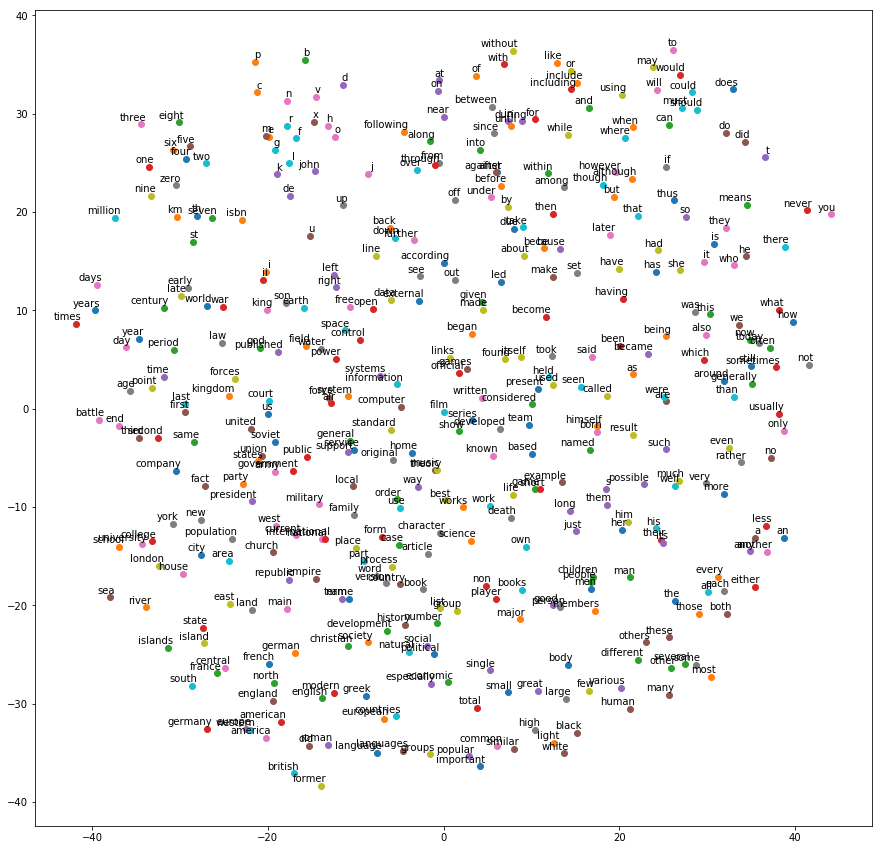

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

### CBOW implementation of word2vec

In [234]:
data_index = 0

def generate_batch(batch_size, cbow_window):
 global data_index
 assert cbow_window % 2 == 1
 span = 2 * cbow_window + 1
 # 去除中心word: span - 1
 batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
 labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

 buffer = collections.deque(maxlen=span)
 for _ in range(span):
     buffer.append(data[data_index])
     # 循环选取 data中数据，到尾部则从头开始
     data_index = (data_index + 1) % len(data)

 for i in range(batch_size):
     # target at the center of span
     target = cbow_window
     # 仅仅需要知道context(word)而不需要word
     target_to_avoid = [cbow_window]

     col_idx = 0
     for j in range(span):
         # 略过中心元素 word
         if j == span // 2:
             continue
         batch[i, col_idx] = buffer[j]
         col_idx += 1
     labels[i, 0] = buffer[target]
     # 更新 buffer
     buffer.append(data[data_index])
     data_index = (data_index + 1) % len(data)

#  assert batch_size[0] == batch_size 
#  assert batch_size[1] == span - 1
 return batch, labels

batch, labels = generate_batch(batch_size=8, cbow_window=1)
for i in range(8):
    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
          batch[i, 1], reverse_dictionary[batch[i, 1]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

5235 anarchism 12 as -> 3083 originated
3083 originated 6 a -> 12 as
12 as 195 term -> 6 a
6 a 2 of -> 195 term
195 term 3134 abuse -> 2 of
2 of 46 first -> 3134 abuse
3134 abuse 59 used -> 46 first
46 first 156 against -> 59 used


In [239]:
reverse_dictionary

{0: 'UNK',
 1: 'the',
 2: 'of',
 3: 'and',
 4: 'one',
 5: 'in',
 6: 'a',
 7: 'to',
 8: 'zero',
 9: 'nine',
 10: 'two',
 11: 'is',
 12: 'as',
 13: 'eight',
 14: 'for',
 15: 's',
 16: 'five',
 17: 'three',
 18: 'was',
 19: 'by',
 20: 'that',
 21: 'four',
 22: 'six',
 23: 'seven',
 24: 'with',
 25: 'on',
 26: 'are',
 27: 'it',
 28: 'from',
 29: 'or',
 30: 'his',
 31: 'an',
 32: 'be',
 33: 'this',
 34: 'which',
 35: 'at',
 36: 'he',
 37: 'also',
 38: 'not',
 39: 'have',
 40: 'were',
 41: 'has',
 42: 'but',
 43: 'other',
 44: 'their',
 45: 'its',
 46: 'first',
 47: 'they',
 48: 'some',
 49: 'had',
 50: 'all',
 51: 'more',
 52: 'most',
 53: 'can',
 54: 'been',
 55: 'such',
 56: 'many',
 57: 'who',
 58: 'new',
 59: 'used',
 60: 'there',
 61: 'after',
 62: 'when',
 63: 'into',
 64: 'american',
 65: 'time',
 66: 'these',
 67: 'only',
 68: 'see',
 69: 'may',
 70: 'than',
 71: 'world',
 72: 'i',
 73: 'b',
 74: 'would',
 75: 'd',
 76: 'no',
 77: 'however',
 78: 'between',
 79: 'about',
 80: 'over'

In [235]:
num_steps = 100001


batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
cbow_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
# pick 16 samples from 100
valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
valid_examples = np.append(valid_examples, random.sample(range(1000, 1000+valid_window), valid_size // 2))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2 * cbow_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # embedding, vector for each word in the vocabulary
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    # this might efficiently find the embeddings for given ids (traind dataset)
    # manually doing this might not be efficient given there are 50000 entries in embeddings
    embeds = None
    for i in range(2 * cbow_window):
        embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
        print('embedding %d shape: %s'%(i, embedding_i.get_shape().as_list()))
        emb_x,emb_y = embedding_i.get_shape().as_list()
        if embeds is None:
            embeds = tf.reshape(embedding_i, [emb_x,emb_y,1])
        else:
            embeds = tf.concat([embeds, tf.reshape(embedding_i, [emb_x, emb_y,1])], 2)

    assert embeds.get_shape().as_list()[2] == 2 * cbow_window
    print("Concat embedding size: %s"%embeds.get_shape().as_list())
    avg_embed =  tf.reduce_mean(embeds, 2, keep_dims=False)
    print("Avg embedding size: %s"%avg_embed.get_shape().as_list())



    loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases,
                           labels=train_labels,
                           inputs=avg_embed,
                           num_sampled=num_sampled,
                           num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    # Adagrad is required because there are too many things to optimize
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, cbow_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

embedding 0 shape: [128, 128]
embedding 1 shape: [128, 128]
Concat embedding size: [128, 128, 2]
Avg embedding size: [128, 128]
Initialized
Average loss at step 0: 277.415649
Nearest to only: julien, uprooted, wollstonecraft, stymied, norton, molybdenum, proceeding, barges,
Nearest to from: endangered, bentheim, activist, sulu, collaborations, galilean, jekyll, zionists,
Nearest to who: anton, feng, slovak, oran, dominos, juliette, software, atheromatous,
Nearest to nine: leo, sasaki, firewall, castles, underworld, ruby, changing, fennel,
Nearest to this: sld, latency, burnett, deterministic, hypothesized, emigration, withers, clocked,
Nearest to most: adv, indoctrination, paymaster, synergy, starter, amphitryon, trudeau, bedrock,
Nearest to if: vigilante, viii, navier, transmutations, simplistic, cells, blume, stimulants,
Nearest to two: paymaster, asphalt, poor, hyperbolic, financier, multiplying, celebrations, perform,
Nearest to http: agis, riggs, foggy, incomprehensible, varese, s

Average loss at step 52000: 4.125585
Average loss at step 54000: 4.094945
Average loss at step 56000: 4.061002
Average loss at step 58000: 3.963650
Average loss at step 60000: 4.012650
Nearest to only: jati, just, still, transcendentalist, win, regroup, electrification, even,
Nearest to from: through, during, into, under, towards, within, chanter, fd,
Nearest to who: he, she, they, often, never, still, actually, quickly,
Nearest to nine: eight, seven, six, five, four, zero, three, two,
Nearest to this: which, it, some, the, any, what, eph, legion,
Nearest to most: more, many, less, some, among, vulcan, abbots, washed,
Nearest to if: when, after, before, stallone, affirmative, thus, where, qassam,
Nearest to two: three, four, six, five, eight, seven, one, nine,
Nearest to http: agis, symbolically, cgs, varese, cheesemaking, foggy, archaeoastronomy, riggs,
Nearest to universe: lamborghini, unchangeable, supranationalism, stake, vaccines, nage, td, gamsakhurdia,
Nearest to ocean: capybara